In [66]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import uniform, norm
from glob import glob
from os.path import join, abspath
from os import pardir
import sys
import vaex
import os
import emcee
from multiprocessing import Pool
from time import time
import corner
from tqdm import tqdm

# Utils functions

In [2]:
def plot_chain(samples, labels, figsize=(10, 7), alpha=0.3, start=0):
    num = len(labels)
    fig, axes = plt.subplots(num, figsize=figsize, sharex=True)
    if len(labels) == 1:
      axes = [axes]
    for i in range(num):
        ax = axes[i]
        ax.plot(samples[start:, :, i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples[start:, :, i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

In [3]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [4]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [5]:
from utils import nu_mod, fw, safe_mkdir

In [6]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [7]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution")
data_eff_dir = join(root_data_dir, "Effective-Volume")

In [8]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [17]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

# Math

let $Z=\{z_i\}$ is a collection of vertical positions of the stars, and $W=\{w_i\}$ is a collection of vertical velocities of the stars. We assume that the vertical positions and velocities are independent. $Z$ and $W$ are inhomogeneous Poisson processes with intensity $\lambda(z)$ and $\mu(w)$ respectively. The intensity $\lambda(z)$ is the number density of star in vertical direction, and $\mu(w)$ is the number density of stars at some velocity $w$.

From previous notebook, the intensity $\lambda(z)$ can be calculated depent on the following parameters $\theta$:
* $\rho_{i}$ - the density of the baryons
* $\sigma_{z,i}$ - baryons velocity dispersion in vertical direction
* $\rho_{\text{DM}}$ - the density of the dark matter halo in the vicinity of the sun
* $\Sigma_{\text{DD}}$ - surface density of dark disk
* $h_{\text{DD}}$ - the vertical scale height of dark disk
* $\nu_0$ - the number density of stars in the midplane disk
* $z_{\odot}$ - the position of the sun
* $R$ - Oort constant radial contribution
* $\sigma_w$ - the velocity dispersion of the stars in vertical direction
* $w_0$ - the velocity of the sun

So,
\begin{aligned}
  \lambda (z) &= f(z;\theta) \\
  &= \nu(z;\theta) \mathcal{F} (z) \\
  &= \nu_0 \exp \left[ -\frac{\Phi(z+z_{\odot};\rho_i,\sigma_{z,i}, \rho_{\text{DM}}, \Sigma_{\text{DD}}, h_{\text{DD}}, R )}{\sigma_w^2} \right] \mathcal{F} (z)\\
\end{aligned}

Where $\mathcal{F} (z)$ is the completeness function

and the same goes for the intensity $\mu(w)$:
\begin{aligned}
  \mu (w) &= g(w;\theta) \\
  &= N_0\mathcal{N}(w;\sigma_w, w_0)
\end{aligned}

Where $N_0$ is the normalization constant

# Framework

by using Bayesian Statistics, we can calculate the posterior distribution of the parameters $\theta$ given the data $Z$ and $W$:
\begin{aligned}
  p_\text{pos}(\theta|Z,W) &= \frac{p_\text{like}(Z,W|\theta)p_\text{prior}(\theta)}{p_\text{ev}(Z,W)} \\
  &\propto p_\text{like,Z}(Z|\theta)p_\text{like,W}(W|\theta) p_0(\theta) \\
  &\propto \mathcal{L}_z(Z|\theta)\mathcal{L}_w(W|\theta) p_0(\theta) \\
  \text{log } p_\text{pos}(\theta|Z,W) &= \text{log } \mathcal{L}_z(Z|\theta) + \text{log } \mathcal{L}_w(W|\theta) + \text{log } p_0(\theta) + C\\
\end{aligned}

Where the likelihood is the likelihood of inhomogeneous Poisson process,
\begin{aligned}
  \text{log } \mathcal{L}_z(Z|\theta) &= \sum_i \log \lambda(z_i) - \int \lambda(z) \text{ d}z \\
  \text{log } \mathcal{L}_w(W|\theta) &= \sum_i \log \mu(w_i) - \int \mu(w) \text{ d}w \\
\end{aligned}

### Prior

Either we can use a uniform prior or a Gaussian prior. The uniform prior is represented by [lower, upper].
| Parameter | Prior | Description |
| --- | --- | --- |
| $\rho_{i}$ | Gaussian | Check the baryons table |
| $\sigma_{z,i}$ | Gaussian | Check the baryons table |
| $\rho_{\text{DM}}$ | [0, 0.06] msun/pc^3 |  |
| $\Sigma_{\text{DD}}$ | [0, 30] msun/pc^2 | |
| $h_{\text{DD}}$ | [0, 100] pc |  |
| $\text{log }\nu_0$ | [12, 13] | A star (star/kpc^3) |
|  | [14, 14.4] | F star |
|  | [13.8, 14] | G star |
| $z_{\odot}$ | [-50, 50] pc | |
| $R$ | Gaussian | mean=3.4E-3, std=0.6E-3 in msun/pc^3|
| $\sigma_w$ | [1, 20] km/s | |
| $w_0$ | [-20, 20] km/s | |

# Prototyping

In [9]:
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
number_files

['/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.37)_(0.40).hdf5']

In [10]:
index = 0
df_number = vaex.open(number_files[index])
df_number

#,z,density_corr,density,density_err
0,-189.4736842105263,5.0102322339836605e-06,3.678247573679359e-06,4.912936909368127e-07
1,-168.42105263157896,5.769611755526935e-06,4.208764050652343e-06,5.288994424727842e-07
2,-147.36842105263156,7.662445449505041e-06,5.55273912565057e-06,6.115297216198587e-07
3,-126.3157894736842,1.0416962868488793e-05,7.497966207884847e-06,7.15439947124087e-07
4,-105.26315789473684,1.4594550822695601e-05,1.0433490713802027e-05,8.497276008511714e-07
...,...,...,...,...
14,105.26315789473685,1.434718555451432e-05,1.0256651888144366e-05,8.424957450740081e-07
15,126.31578947368422,1.0515236103097178e-05,7.568701738147911e-06,7.188067419418892e-07
16,147.36842105263162,8.248110069849377e-06,5.977152307228958e-06,6.344700053730289e-07
17,168.421052631579,6.205968947121409e-06,4.527073936836134e-06,5.485353407928359e-07


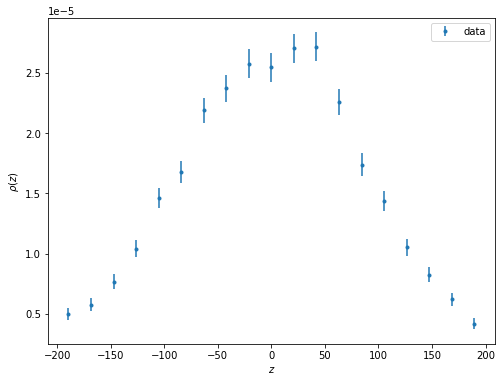

In [11]:
zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

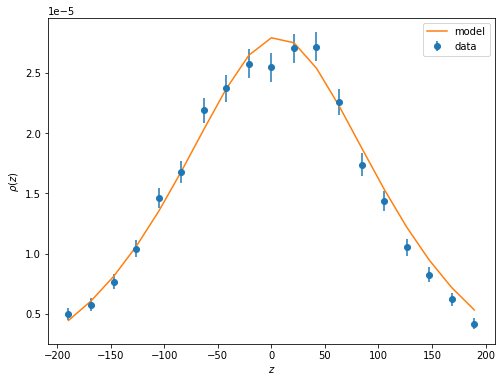

In [12]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 2.8E-5
zsun = -6

theta_dict = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R,
    sigma_w=np.array([8]),
    w0=np.array([-7]),
    a=np.array([1])
)

nu = nu_mod(zmid, **theta_dict)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
ax.plot(zmid, nu, label='model')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

In [13]:
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.37)_(0.40).hdf5']

In [14]:
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()
velocity_popt_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.37)_(0.40).hdf5']

In [15]:
df_velocity = vaex.open(velocity_files[index])
df_velocity

#,w,wnum,werr
0,-67.58620689655172,8.05376582981559e-05,5.6948724323511066e-05
1,-62.758620689655174,4.026882914907795e-05,4.026882914907795e-05
2,-53.10344827586207,4.026882914907795e-05,4.026882914907795e-05
3,-48.275862068965516,8.05376582981559e-05,5.6948724323511066e-05
4,-38.62068965517241,0.00024161297489446772,9.863808395455469e-05
...,...,...,...
17,24.137931034482754,0.0001610753165963118,8.05376582981559e-05
18,28.96551724137931,0.00012080648744723386,6.974765804751361e-05
19,33.79310344827586,8.05376582981559e-05,5.6948724323511066e-05
20,38.620689655172406,0.0001610753165963118,8.05376582981559e-05


In [16]:
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
popt

array([ 0.07941616, -6.3139583 ,  2.75078696,  0.91130269, -7.25885714,
        7.87732938])

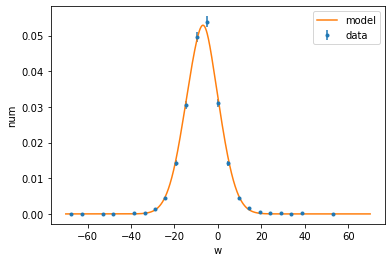

In [17]:
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()

w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

ws = np.linspace(-70, 70, 1000)
Fw = fw(ws, **theta)

# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
ax.plot(ws, Fw, label='model')
ax.set_xlabel(r'w')
ax.set_ylabel(r'num')
ax.legend()
plt.show()

In [18]:
args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'nu0', 'zsun', 'R', 'sigma_w', 'w0', 'a')

args_loc = tuple(item+"_loc" for item in args)
args_loc

('rhos_loc',
 'sigmaz_loc',
 'rhoDM_loc',
 'sigmaDD_loc',
 'hDD_loc',
 'nu0_loc',
 'zsun_loc',
 'R_loc',
 'sigma_w_loc',
 'w0_loc',
 'a_loc')

In [19]:
uni_list = ['log_rhoDM', 'log_sigmaDD', 'log_hDD', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list = ['rhos', 'sigmaz', 'R']
args = tuple(norm_list+uni_list)
args

('rhos',
 'sigmaz',
 'R',
 'log_rhoDM',
 'log_sigmaDD',
 'log_hDD',
 'log_nu0',
 'zsun',
 'log_sigma_w',
 'w0',
 'a')

In [21]:
uni_list = ['log_rhoDM', 'log_sigmaDD', 'log_hDD', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list = ['rhos', 'sigmaz', 'R']
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [22]:
locs = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    log_rhoDM=np.log(0.005), 
    log_sigmaDD=np.log(1), 
    log_hDD=np.log(1), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhos=e_rhos, 
    sigmaz=e_sigmaz, 
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_sigmaDD=np.log(50)-locs['log_sigmaDD'], 
    log_hDD=np.log(100)-locs['log_hDD'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=10, 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)
locs, scales

({'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ]),
  'log_rhoDM': -5.298317366548036,
  'log_sigmaDD': 0.0,
  'log_hDD': 0.0,
  'log_nu0': -11.512925464970229,
  'zsun': -20,
  'R': 0.0034,
  'w0': array([-11.3139583 , -12.25885714]),
  'log_sigma_w': array([0.65521209, 1.70731399]),
  'a': array([0.05559131, 0.63791188])},
 {'rhos': array([3.12e-03, 5.54e-03, 7.00e-04, 3.00e-05, 6.00e-05, 1.80e-04,
         1.80e-04, 2.90e-04, 7.20e-04, 2.80e-03, 1.00e-03, 5.00e-04]),
  'sigmaz': array([0.2, 0.5, 2.4, 4. , 1.6, 2. , 2.4, 1.8, 1.9, 4. , 5. , 5. ]),
  'log_rhoDM': 2.995732273553991,
  'log_sigmaDD': 3.912023005428146,
  'log_hDD': 4.605170185988092,
  'log_nu0': 2.302585092994047,
  'zsun': 40,
  'R': 0.0006,
  'w0': 10,
  'log_sigma_w': array([0.61903921, 0.61903921]),
  'a': array([0.0476497 , 0.54678161])})

In [23]:
dim=len(popt)//3
theta_dict = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    log_rhoDM=np.log(rhoDM), 
    log_sigmaDD=np.log(sigmaDD), 
    log_hDD=np.log(hDD), 
    log_nu0=np.log(4E-5), 
    zsun=20, 
    R=R, 
    w0=w0, 
    log_sigma_w=np.log(sigma_w), 
    a=a_raw
)

log_prior(theta_dict, locs, scales, norm_list, uni_list)

59.48214484600671

In [24]:
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [25]:
zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])

log_likelihood(theta_dict, zdata, wdata)

-196.03751326210295

In [27]:
def log_posterior(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=theta[:12],
        sigmaz=theta[12:24],
        log_rhoDM=theta[24],
        log_sigmaDD=theta[25],
        log_hDD=theta[26],
        log_nu0=theta[27],
        zsun=theta[28],
        R=theta[29],
        w0=theta[30:30+dim],
        log_sigma_w=theta[30+dim:30+2*dim],
        a=theta[30+2*dim:30+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
    theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
    theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [28]:
theta = [
    rhos, 
    sigmaz, 
    np.log(rhoDM), 
    np.log(sigmaDD), 
    np.log(hDD), 
    np.log(4E-5), 
    20, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])
log_posterior(theta, (zdata, wdata), locs, scales, dim, norm_list, uni_list)

-136.55536841609623

In [29]:
def log_posterior_simple_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        log_rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [30]:
# dm only

theta = [
    np.log(rhoDM), 
    np.log(4E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    log_rhoDM=np.log(0.005), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

log_posterior_simple_DM(theta, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM), theta.shape

(-770.8533909046993, (10,))

# MCMC

In [10]:
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
number_files

['/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.37)_(0.40).hdf5']

In [11]:
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.37)_(0.40).hdf5']

In [12]:
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()
velocity_popt_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.37)_(0.40).hdf5']

In [172]:
name = "MCMC"
data_dir = join(root_data_dir, name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/MCMC already exist. Good to go!


# Prob

In [163]:
# prior
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [164]:
# likelihood
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [165]:
# posterior DM only
def log_posterior_simple_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        log_rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [23]:
# Loading data
index = 0
df_number = vaex.open(number_files[index])
df_number

#,z,density_corr,density,density_err
0,-189.4736842105263,5.0102322339836605e-06,3.678247573679359e-06,4.912936909368127e-07
1,-168.42105263157896,5.769611755526935e-06,4.208764050652343e-06,5.288994424727842e-07
2,-147.36842105263156,7.662445449505041e-06,5.55273912565057e-06,6.115297216198587e-07
3,-126.3157894736842,1.0416962868488793e-05,7.497966207884847e-06,7.15439947124087e-07
4,-105.26315789473684,1.4594550822695601e-05,1.0433490713802027e-05,8.497276008511714e-07
...,...,...,...,...
14,105.26315789473685,1.434718555451432e-05,1.0256651888144366e-05,8.424957450740081e-07
15,126.31578947368422,1.0515236103097178e-05,7.568701738147911e-06,7.188067419418892e-07
16,147.36842105263162,8.248110069849377e-06,5.977152307228958e-06,6.344700053730289e-07
17,168.421052631579,6.205968947121409e-06,4.527073936836134e-06,5.485353407928359e-07


In [24]:
zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

In [25]:
# loading velocity data
df_velocity = vaex.open(velocity_files[index])
df_velocity

#,w,wnum,werr
0,-67.58620689655172,8.05376582981559e-05,5.6948724323511066e-05
1,-62.758620689655174,4.026882914907795e-05,4.026882914907795e-05
2,-53.10344827586207,4.026882914907795e-05,4.026882914907795e-05
3,-48.275862068965516,8.05376582981559e-05,5.6948724323511066e-05
4,-38.62068965517241,0.00024161297489446772,9.863808395455469e-05
...,...,...,...
17,24.137931034482754,0.0001610753165963118,8.05376582981559e-05
18,28.96551724137931,0.00012080648744723386,6.974765804751361e-05
19,33.79310344827586,8.05376582981559e-05,5.6948724323511066e-05
20,38.620689655172406,0.0001610753165963118,8.05376582981559e-05


In [26]:
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
popt

array([ 0.07941616, -6.3139583 ,  2.75078696,  0.91130269, -7.25885714,
        7.87732938])

In [30]:
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()

dim = len(popt)//3

w0 = []
sigma_w = []
a_raw = []

for i in range(dim):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

In [32]:
# dm only

theta = [
    np.log(0.02), 
    np.log(4E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    log_rhoDM=np.log(0.005), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

log_posterior_simple_DM(theta, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM), theta.shape

(-666.4895254640188, (10,))

In [35]:
theta = np.concatenate([np.ravel(x) for x in locs.values()])

ndim = len(theta)
nwalkers = ndim*2+1
pars_list = uni_list_DM + norm_list_DM
index = 0

log_rhoDM_0 = np.random.uniform(low=locs['log_rhoDM'], high=locs['log_rhoDM']+scales['log_rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([log_rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
p0.shape

(21, 10)

In [36]:
p00 = p0[3]
theta_dict = dict(
    log_rhoDM=p00[0],
    log_nu0=p00[1],
    zsun=p00[2],
    R=p00[3],
    w0=p00[4:4+dim],
    log_sigma_w=p00[4+dim:4+2*dim],
    a=p00[4+2*dim:4+3*dim]
)

log_prior(theta_dict, locs, scales, norm_list_DM, uni_list_DM)

0.23535943688034067

In [37]:
log_posterior_simple_DM(p0[2], (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM)

268.81491465993

100%|██████████| 500/500 [00:40<00:00, 12.22it/s]


Multiprocessing took 41.0 seconds


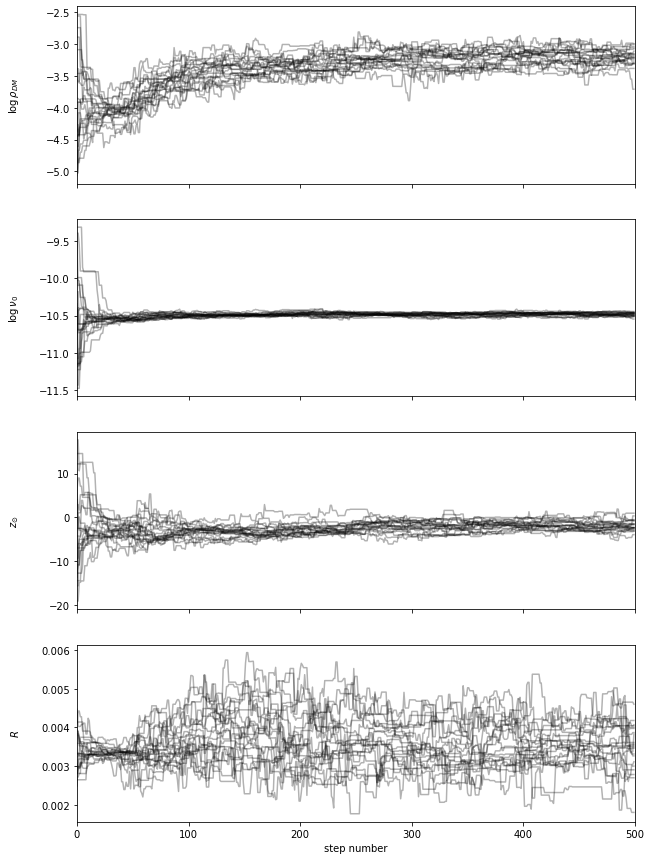

In [38]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

100%|██████████| 2000/2000 [02:39<00:00, 12.54it/s]


Multiprocessing took 159.6 seconds


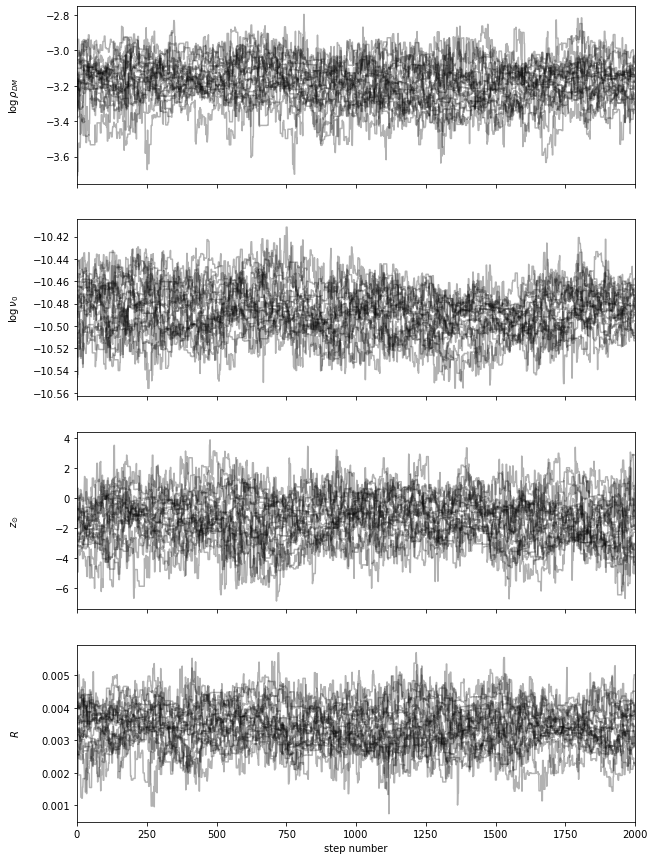

In [39]:
next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

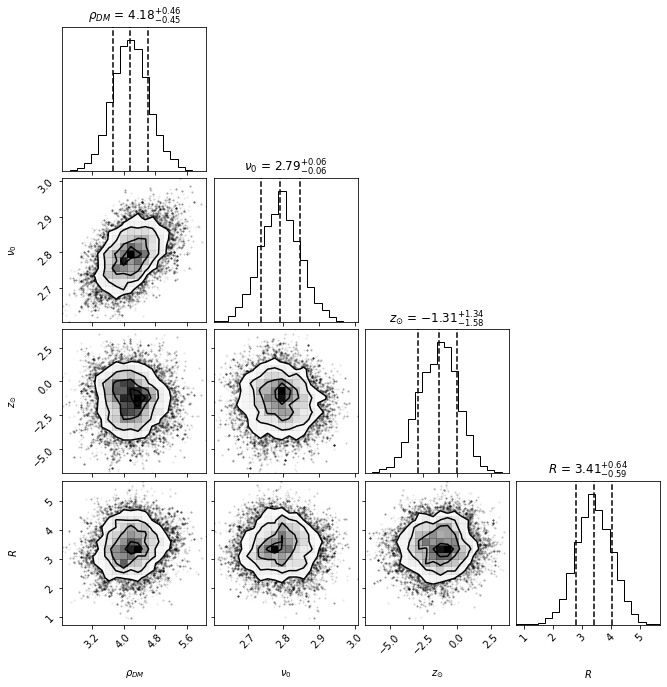

In [40]:
flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = np.exp(flat_samples[:, 0])/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3


labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]

labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

100%|██████████| 500/500 [01:42<00:00,  4.86it/s]


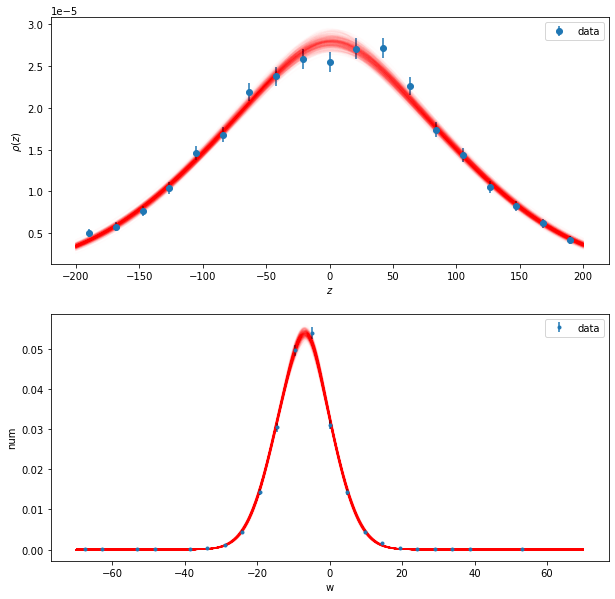

In [41]:
# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.01
zs = np.linspace(-200, 200, 100)
ws = np.linspace(-70, 70, 1000)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in tqdm(range(500)):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=np.exp(flat_samples[index, 0]),
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()

# All in one go

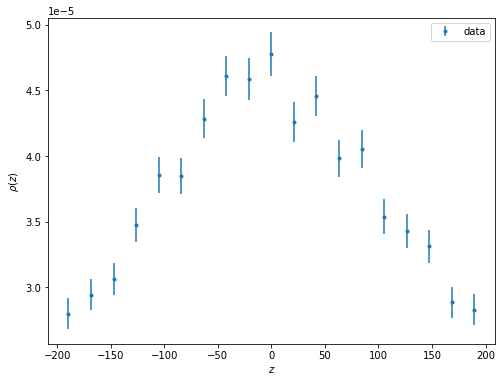

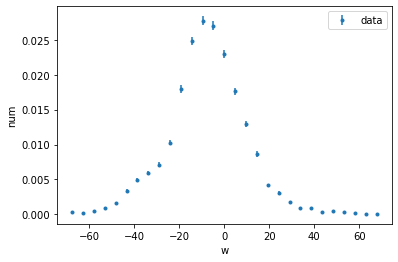

100%|██████████| 500/500 [00:50<00:00,  9.82it/s]


Multiprocessing took 51.1 seconds


100%|██████████| 2000/2000 [03:25<00:00,  9.74it/s]


Multiprocessing took 205.4 seconds


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


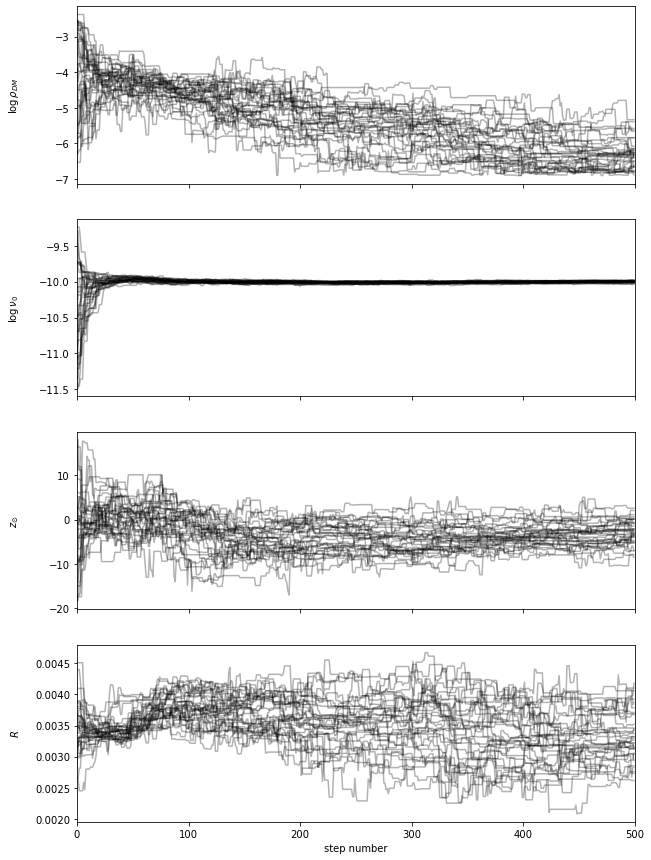

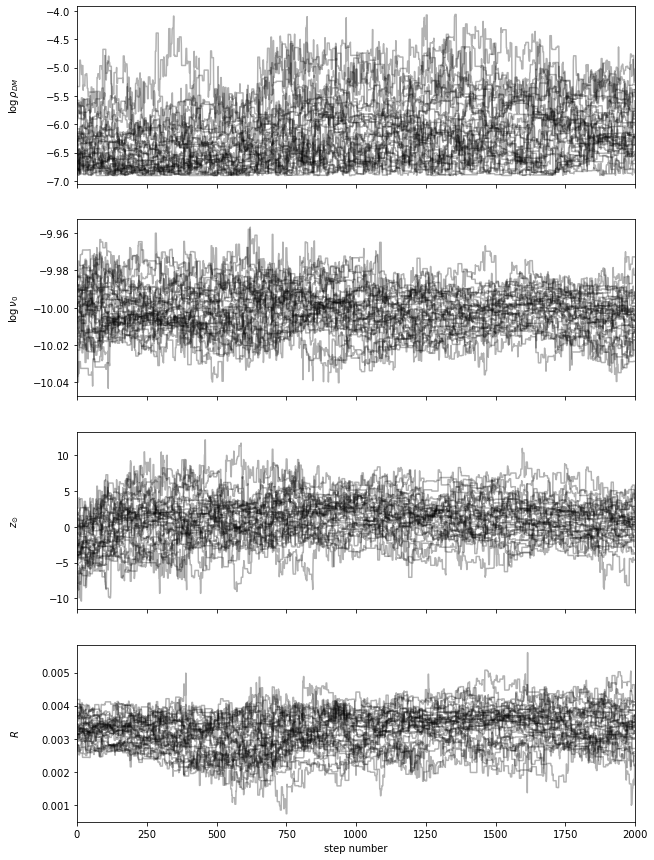

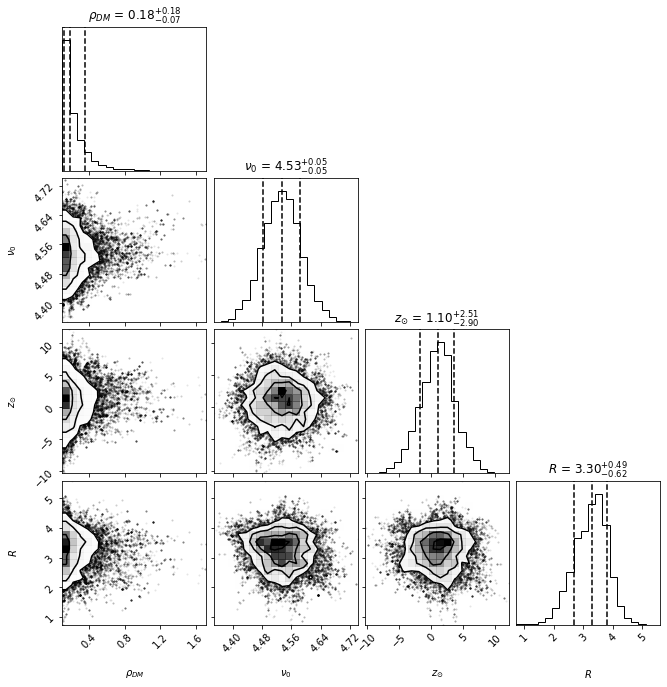

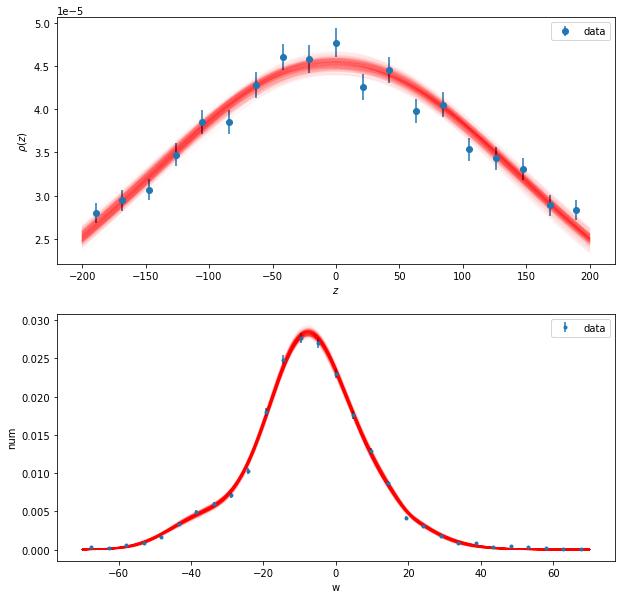

In [43]:
index = 3
# loading the data
df_number = vaex.open(number_files[index])
df_velocity = vaex.open(velocity_files[index])
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()
dim = len(popt)//3

zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)
data = (zdata, wdata)

# ======================================
# plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
ax.set_xlabel(r'w')
ax.set_ylabel(r'num')
ax.legend()
plt.show()
# ======================================
# initialize the locs and scales
# dm only
locs = dict(
    log_rhoDM=np.log(0.001), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)
uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']
# ======================================
# initialize the walkers

theta = np.concatenate([np.ravel(x) for x in locs.values()])
ndim = len(theta)
nwalkers = ndim*2+1

log_rhoDM_0 = np.random.uniform(low=locs['log_rhoDM'], high=locs['log_rhoDM']+scales['log_rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([log_rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T

os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = np.exp(flat_samples[:, 0])/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3


labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]

labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.01
zs = np.linspace(-200, 200, 100)
ws = np.linspace(-70, 70, 1000)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in tqdm(range(500)):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=np.exp(flat_samples[index, 0]),
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()

In [160]:
def load_data(index, number_files, velocity_files, velocity_popt_files):
    name = number_files[index].split('/')[-1]
    df_number = vaex.open(number_files[index])
    df_velocity = vaex.open(velocity_files[index])
    df_popt = vaex.open(velocity_popt_files[index])
    popt = df_popt['popt'].to_numpy()
    wdens= df_velocity['wnum'].to_numpy()
    werr = df_velocity['werr'].to_numpy()
    wmid = df_velocity['w'].to_numpy()
    dim = len(popt)//3

    zdens = df_number['density_corr'].to_numpy()
    zerr = df_number['density_err'].to_numpy()
    zmid = df_number['z'].to_numpy()

    w0 = []
    sigma_w = []
    a_raw = []

    for i in range(len(popt)//3):
        w0_i = popt[3*i+1]
        sigma_w_i = popt[3*i+2]
        a_raw_i = popt[3*i]
        
        w0.append(w0_i)
        sigma_w.append(sigma_w_i)
        a_raw.append(a_raw_i)

    w0 = np.array(w0)
    sigma_w = np.array(sigma_w)
    a_raw = np.array(a_raw)

    zdata = (zmid, zdens, zerr)
    wdata = (wmid, wdens, werr)
    data = (zdata, wdata)
    return data, dim, w0, sigma_w, a_raw, name

In [56]:
def plot_data(data):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata

    # plot 2 subplot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_ylabel(r'$\rho(z)$ [pc$^{-3}$]')
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_ylabel(r'$f_w$')
    plt.show()


In [61]:
def initialize_prior_dm(w0, sigma_w, a_raw, dim):
    locs = dict(
        log_rhoDM=np.log(0.001), 
        log_nu0=np.log(1E-5), 
        zsun=-20, 
        R=3.4E-3, 
        w0=w0-5, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
    )

    scales = dict(
        log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
        log_nu0=np.log(1E-4)-locs['log_nu0'], 
        zsun=20-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(10, dim), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )
    uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    norm_list_DM = ['R']
    return locs, scales, uni_list_DM, norm_list_DM

In [88]:
def initialize_walkers_dm(locs, scales, dim):
    theta = np.concatenate([np.ravel(x) for x in locs.values()])
    ndim = len(theta)
    nwalkers = ndim*2+1

    log_rhoDM_0 = np.random.uniform(low=locs['log_rhoDM'], high=locs['log_rhoDM']+scales['log_rhoDM'], size=nwalkers)
    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = np.array([log_rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    return p0, ndim, nwalkers

In [64]:
def run_mcmc(nwalkers, ndim, p0, labels, log_posterior, args, cores=16, plot=False, step=500):
    os.environ["OMP_NUM_THREADS"] = str(cores)
    sampler_ = 0
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, 
            ndim, 
            log_posterior, 
            args=args, 
            pool=pool
        )
        start = time()
        state = sampler.run_mcmc(p0, step, progress=True)
        samples = sampler.get_chain()
        end = time()
        multi_time = end - start
        if plot:
            plot_chain(samples, labels, figsize=(10,15))
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        sampler_ = sampler
    return sampler_

In [49]:
def plot_corner_dm(sampler):
    flat_samples = sampler.get_chain(flat=True).copy()
    flat_samples = flat_samples[:, :4]
    flat_samples[:, 0] = np.exp(flat_samples[:, 0])/1E-2
    flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
    flat_samples[:, 3] = flat_samples[:, 3]/1E-3

    labels = [r"$\rho_{DM}\times 10^2$",r"$\nu_0 10^5$ " , r"$z_{\odot}$", r"$R\times 10^3$"]
    fig = corner.corner(
        flat_samples, labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, title_kwargs={"fontsize": 12},
    )

In [96]:
def plot_fitting_dm(sampler, data, dim, rhos, sigmaz, alpha=0.01, n=200):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    # plot two subplot
    flat_samples = sampler.get_chain(flat=True).copy()
    zs = np.linspace(-200, 200, 100)
    ws = np.linspace(-70, 70, 1000)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\rho(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'num')
    axes[1].legend()
    for i in tqdm(range(n)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            rhos=rhos, 
            sigmaz=sigmaz, 
            rhoDM=np.exp(flat_samples[index, 0]),
            sigmaDD=0, 
            hDD=1, 
            nu0=np.exp(flat_samples[index, 1]),
            zsun=flat_samples[index, 2],
            R=flat_samples[index, 3],
            w0=flat_samples[index, 4:4+dim],
            sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
            a=flat_samples[index, 4+2*dim:4+3*dim]
        )
        nu = nu_mod(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    plt.show()

# Let's try

gaia_(0.19)_(0.25).hdf5


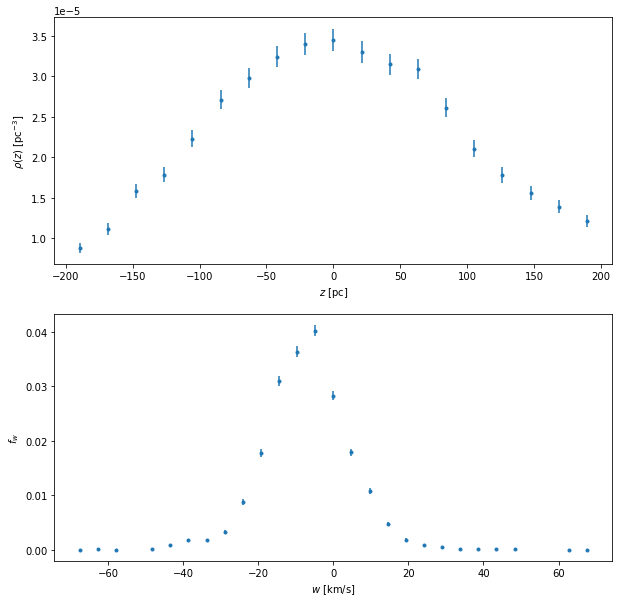

In [161]:
data, dim, w0, sigma_w, a_raw, name = load_data(1, number_files, velocity_files, velocity_popt_files)
print(name)
plot_data(data)

locs, scales, uni_list_DM, norm_list_DM = initialize_prior_dm(w0, sigma_w, a_raw, dim)

p0, ndim, nwalkers = initialize_walkers_dm(locs, scales, dim)

100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]


Multiprocessing took 98.7 seconds


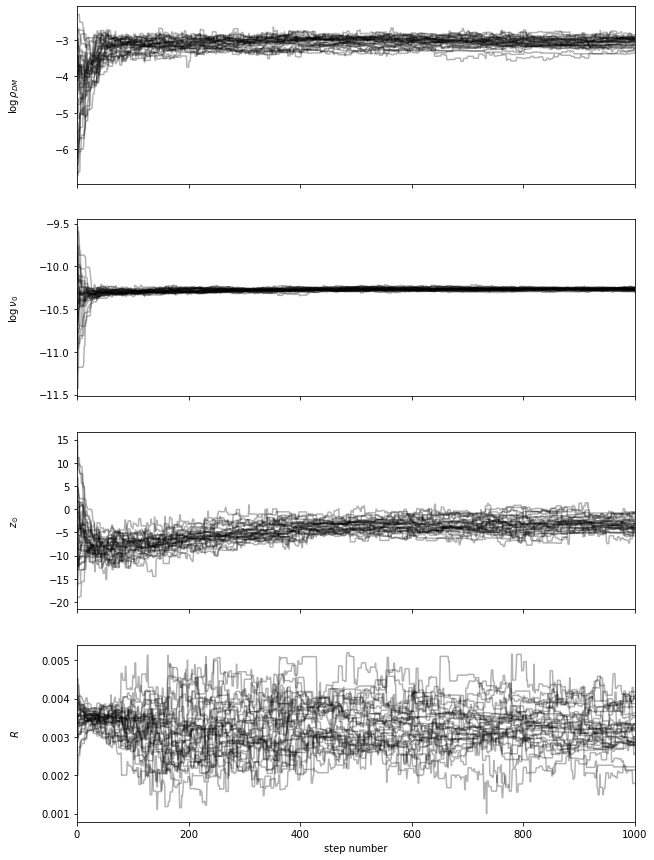

In [166]:
sampler = run_mcmc(
    nwalkers, ndim, p0, labels, log_posterior_simple_DM,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    cores=16, plot=True, step=1000)

100%|██████████| 5000/5000 [08:25<00:00,  9.89it/s]


Multiprocessing took 505.8 seconds


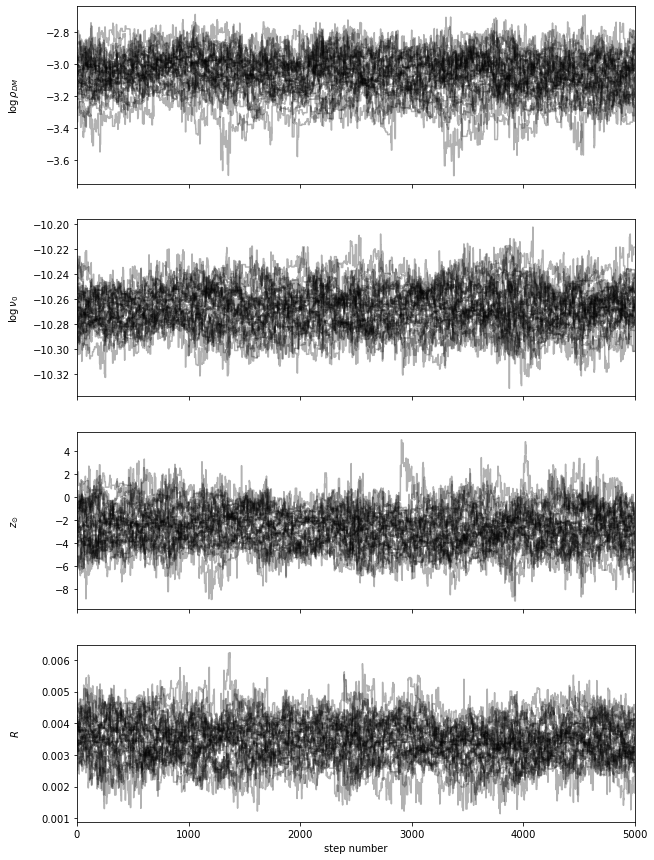

In [107]:
next_p0 = sampler.get_chain()[-1]
# next_p0 = sampler_new.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, labels, log_posterior_simple_DM,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    cores=16, plot=True, step=5000)

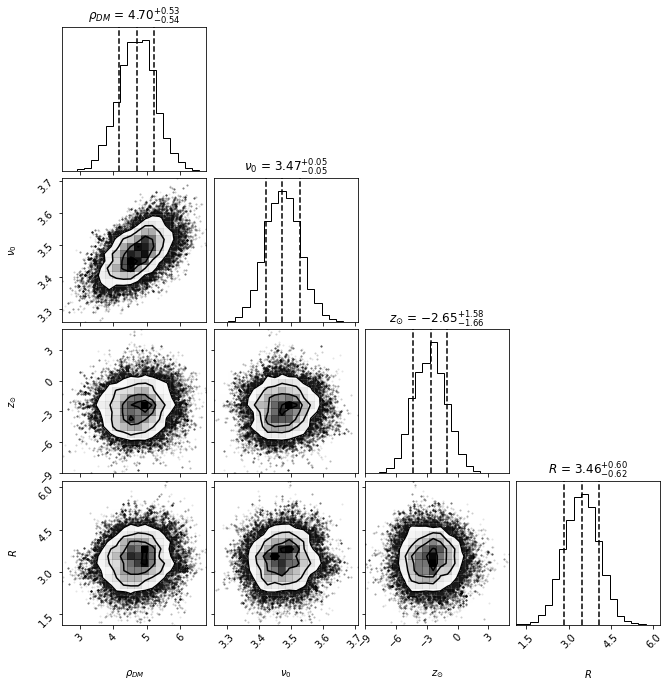

In [167]:
plot_corner_dm(sampler_new)

100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


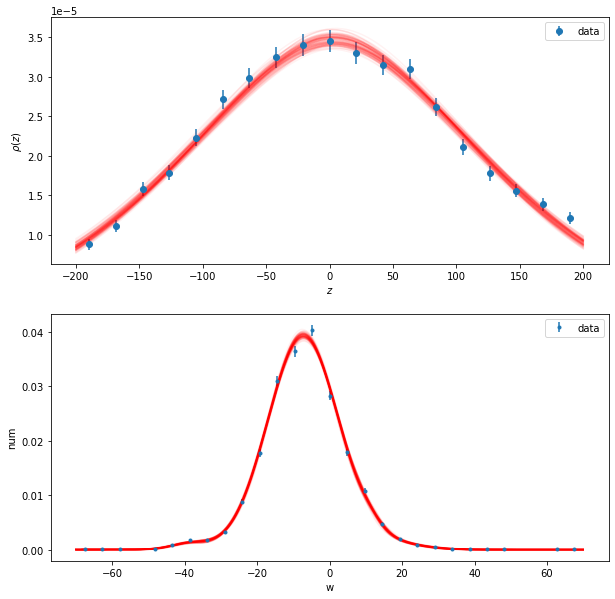

In [168]:
plot_fitting_dm(sampler_new, data, dim, rhos, sigmaz, alpha=0.05, n=100)

In [169]:
flat_samples = sampler.get_chain(flat=True).copy()
log_posterior = sampler.get_log_prob(flat=True).copy()
# save priors
log_priors = []
for samples in tqdm(flat_samples):
    theta = {
        "log_rhoDM": samples[0],
        "log_nu0": samples[1],
        "zsun": samples[2],
        "R": samples[3],
        "w0": samples[4:4+dim],
        "log_sigma_w": samples[4+dim:4+2*dim],
        "a": samples[4+2*dim:4+3*dim]
    }
    lg_prior = log_prior(theta, locs, scales, norm_list_DM, uni_list_DM)
    log_priors.append(lg_prior)

log_priors = np.array(log_priors)
log_likelihood = log_posterior - log_priors

100%|██████████| 33000/33000 [00:33<00:00, 994.37it/s] 


In [170]:
flat_samples = sampler.get_chain(flat=True).copy()
df_dm = {
    "log_rhoDM": flat_samples[:, 0],
    "log_nu0": flat_samples[:, 1],
    "zsun": flat_samples[:, 2],
    "R": flat_samples[:, 3],
}
for i in range(dim):
    df_dm[f"w0_{i}"] = flat_samples[:, 4+i]
    df_dm[f"log_sigma_w_{i}"] = flat_samples[:, 4+dim+i]
    df_dm[f"a_{i}"] = flat_samples[:, 4+2*dim+i]
df_dm["log_likelihood"] = log_likelihood
df_dm["log_prior"] = log_priors
df_dm["log_posterior"] = log_posterior
df_dm = vaex.from_dict(df_dm)
df_dm

#,log_rhoDM,log_nu0,zsun,R,w0_0,log_sigma_w_0,a_0,w0_1,log_sigma_w_1,a_1,w0_2,log_sigma_w_2,a_2,w0_3,log_sigma_w_3,a_3,log_likelihood,log_prior,log_posterior
0,-4.1300623056155334,-11.040624360461726,-4.946815620910096,0.0038733581091210363,-8.69104487461004,2.22222626133214,0.7672121749389194,-36.956658563525025,1.2569889363829274,0.018542658508394864,13.082294398589505,1.0567851039551215,0.02524456562645378,20.574291266031413,1.780875870432553,0.015938712624875517,-819.8924125240401,7.055283489187937,-812.8371290348522
1,-2.6867159803253324,-10.954601397043675,-12.089048746978378,0.0025361693853857485,-8.125532614070789,2.3057065852465164,0.7282867567240755,-42.958177673321835,1.2415051682033518,0.01939839858854924,11.604771321920708,1.1986656737645358,0.025492922688608588,22.366295893695224,2.0430341638222114,0.011773613794427047,-764.5563125836276,6.330095390196003,-758.2262171934316
2,-2.756285859287253,-10.141055025286784,-6.6214838542865895,0.002993012794587167,-8.228942867220898,2.1226715082753618,0.7823118655074907,-34.76729887796355,1.202105370485887,0.017426308193600797,13.738331391005367,1.1524424615092332,0.01571928423121156,19.590848965574146,1.8963311412341575,0.016734160833894736,119.35296282108504,7.13643531432807,126.48939813541311
3,-3.8676541449938475,-9.765972539991179,-12.6058892278989,0.003988821623587842,-11.120382401975236,2.457060501811607,1.1509165276813034,-34.46404739496482,1.5958920564916486,0.016708893917234912,12.837552173096682,1.1992543307567758,0.025775962248555793,20.823191848542994,1.818094485796396,0.013191135622620637,-4814.79940399241,6.8849459823351875,-4807.914458010075
4,-2.3078419739187463,-10.251461604435676,-10.906152719915866,0.0032735710345474,-7.623540367618125,2.3191235083100374,0.8898155962055252,-36.71841680088196,1.579517026868242,0.012528368738317957,6.498396632063892,1.3389417512292638,0.022980232129856237,23.742722539082877,1.8520818095146478,0.014725868619584763,312.7529359358639,7.344288511639643,320.09722444750355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"32,995",-2.8975707913263027,-10.254535183675067,-2.3100527291297936,0.002941447435156561,-7.063568618850634,2.292340974707403,0.6916979662089965,-38.35672921869485,1.7323813691765855,0.02135586863087904,9.229913279576147,0.9436585731556224,0.023759126481338388,20.58790272309233,1.8857409039226396,0.011599047083852792,414.74799698027323,7.074446606890919,421.8224435871642
"32,996",-3.0162943134850018,-10.271213278676179,-3.956402847146853,0.0039968444297902896,-7.257318072393876,2.27685064778547,0.7413445577657531,-38.36383528452719,1.4240398091072055,0.019378347391977135,11.410149527995673,0.8843689867335767,0.026066565342848656,20.75662631086477,2.0020617278815505,0.014295305897215293,412.76563229353724,6.871734358769808,419.63736665230704
"32,997",-2.9230461803392327,-10.267358406023796,-3.0748109002205264,0.0030051833006091992,-7.0269145013532235,2.3008421804000077,0.8220432729050176,-39.28720838229818,1.643253347402638,0.02075161287583936,9.086077773431766,0.8508720230533644,0.026509867386426803,20.980426343309762,1.899739279149922,0.0175998671216757,413.50078644597545,7.149988591066822,420.65077503704225
"32,998",-2.9804414650900357,-10.261326905270243,-2.218636272822679,0.0033381758951761837,-7.196374028039053,2.2782016902642246,0.6869999415379634,-37.72467758177199,1.5593683933257665,0.02134042306313121,12.623587535155954,1.355605010995456,0.022679041712203724,21.655626543396828,1.7652521160250398,0.011968652093742718,416.794488109751,7.361180266317627,424.1556683760686


In [171]:
name

'gaia_(0.19)_(0.25).hdf5'

In [173]:
df_dm.export(join(data_dir, f"dm_simple_{name}.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.12s =  0.0m =  0.0h
 

# Checking

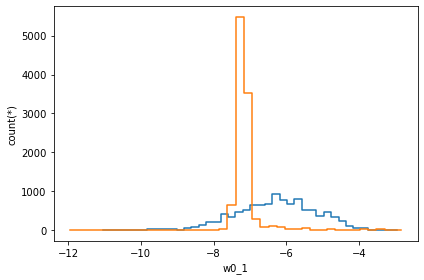

In [104]:
df_dm.viz.histogram('w0_0', shape=40)
df_dm.viz.histogram('w0_1', shape=40)